# Data Import

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
import string

import nltk
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
# Read in and preview the dataset
news = pd.read_json('sarcastic_headlines.json', lines = True)
news.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


# Data Preprocessing

In [3]:
def clean_text(headline):
    '''
    Pre-processing function that cleans the headlines in the news dataset.
    Parameter headline is a string.
    Returns the string headline with no apostrophe s ('s) endings or punctuation marks.
    '''
    words = headline.lower().split()
    cleaned_words = []
    for word in words:
        # Stemming: remove 's endings from words in the headline  
        if word.endswith("'s"):
            cleaned_words.append(word[:-2])  
        # Remove punctuation marks in the headline
        elif any(char in string.punctuation for char in word):
            cleaned_word = ''.join(char for char in word if char not in string.punctuation)
            cleaned_words.append(cleaned_word)
        else:
            cleaned_words.append(word)
    return ' '.join(cleaned_words)

# Clean each text headline  
news['cleaned_headline'] = news['headline'].apply(lambda x: clean_text(x))

# Feature Augmentation

In [4]:
# Define a LabelEncoder to encode categorical features as integers
le = LabelEncoder()

# Identify if a headline has a period 
news['has_period'] = le.fit_transform(news['headline'].str.contains('.', regex = False))

# Identify if a headline has a question mark
news['has_question_mark'] = le.fit_transform(news['headline'].str.contains('?', regex = False))

# Identify if a headline has an exclamation point 
news['has_exclamation_point'] = le.fit_transform(news['headline'].str.contains('!', regex = False))

# Identify if a headline has ellipses
news['has_ellipses'] = le.fit_transform(news['headline'].str.contains('...', regex = False))

# Identify if a headline has single or double quotes
news['has_quotes'] = le.fit_transform(news['headline'].str.contains(r" ['\"]", regex = True))

# Identify if a headline has profanity
profanity_list = ['fuck', 'bitch', 'shit', 'ass']
news['has_profanity'] = le.fit_transform(news['headline'].str.contains('|'.join(profanity_list), case = False))

In [5]:
# Bag of words feature extraction

# 1) Design a sarcastic words vocabulary containing frequently used words among the sarcastic headlines

# Filter the cleaned headlines labeled as sarcastic
sarcastic_cleaned_headlines = news[news['is_sarcastic'] == 1]['cleaned_headline'].tolist()

# Initialize a tokenizer 
tokenizer = WordPunctTokenizer()

# Tokenize the sarcastic cleaned headlines into lists of words
tokens = [tokenizer.tokenize(headline) for headline in sarcastic_cleaned_headlines]

# Count the frequency of each word across all the sarcastic cleaned headlines
word_counts = Counter()
for headline_tokens in tokens:
    word_counts.update(headline_tokens)

# Identify words that might indicate sarcasm based on whether their frequency is >= 10
threshold = 10 
sarcastic_words = [word for word, count in word_counts.items() if count >= threshold]

# 3) Create a TFIDF bag of words for each headline based on sarcastic_words 

# Define a TFIDF vectorizer to convert each headline to a bag of words using the saracstic_words vocabulary 
vectorizer = TfidfVectorizer(vocabulary = sarcastic_words)

# Store the TFIDF counts for each headline and the corresponding sarcastic_words feature names in a DataFrame
tfidf_counts = vectorizer.fit_transform(news['headline'].values.astype(str))
tfidf_counts_df = pd.DataFrame(tfidf_counts.toarray(), columns = vectorizer.get_feature_names_out())

# Augment the news DataFrame with the features in tfidf_counts_df                                      
news = pd.concat((news, tfidf_counts_df), axis = 1)

In [6]:
# Preview the dataset with the augmented features 
news.head()

,article_link,headline,is_sarcastic,cleaned_headline,has_period,has_question_mark,has_exclamation_point,has_ellipses,has_quotes,has_profanity,...,guide,45,lobby,destroy,ancient,winter,stranger,fully,style,guitar
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,former versace store clerk sues over secret bl...,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,the roseanne revival catches up to our thorny ...,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,mom starting to fear son web series closest th...,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,boehner just wants wife to listen not come up ...,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wishes snape happy birthday in the ...,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis

In [7]:
# View the dimensions of the dataset; the dataset has 26709 rows and 1915 columns  
news.shape

(26709, 1915)

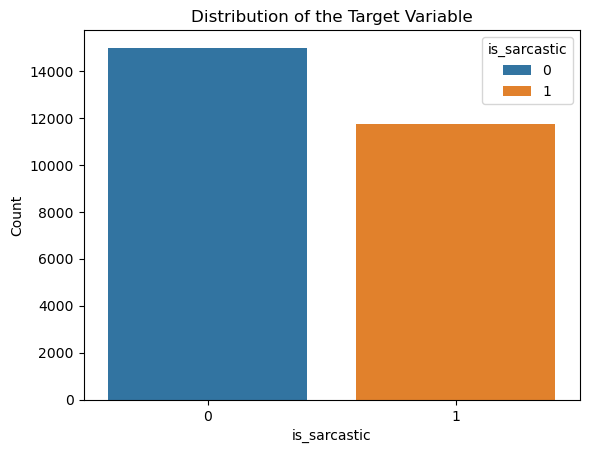

In [8]:
# View the distribution of the target variable; the dataset is slightly unbalanced 
plt.figure()
sns.countplot(data = news, x = 'is_sarcastic',  hue = 'is_sarcastic')
plt.title('Distribution of the Target Variable')
plt.ylabel('Count')
plt.show()

In [9]:
# View the percentage of missing values per column; the dataset does not contain any missing values
missing_value_df = pd.DataFrame({'column_name': news.columns,
                                 'percent_missing': news.isnull().sum() * 100 / len(news)})
missing_value_df

,column_name,percent_missing
article_link,article_link,0.0
headline,headline,0.0
is_sarcastic,is_sarcastic,0.0
cleaned_headline,cleaned_headline,0.0
has_period,has_period,0.0
...,...,...
winter,winter,0.0
stranger,stranger,0.0
fully,fully,0.0
style,style,0.0


/Users/aidamohasesi/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

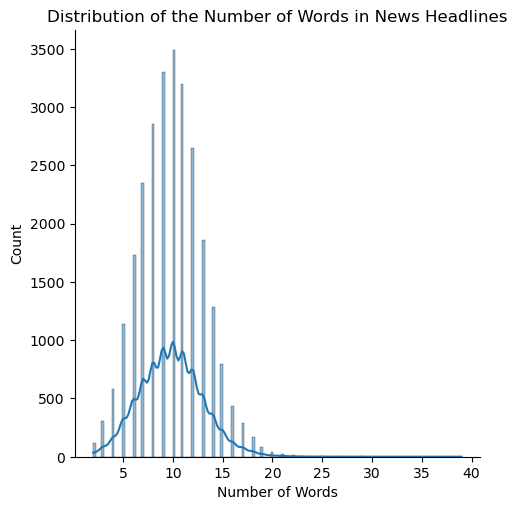

In [10]:
# View the distribution of the number of words in the headlines; most headlines are less than 20 words long
def get_length(headline):
    '''
    Function that gets the length of the headlines in the news dataset.
    Parameter headline is a string.
    Returns an integer representing the length (number of words) in the string headline.
    '''
    return len(headline.split())

plt.figure()
sns.displot(data = news, x = news['headline'].apply(get_length), kde = True)
plt.title('Distribution of the Number of Words in News Headlines')
plt.xlabel('Number of Words')
plt.show()

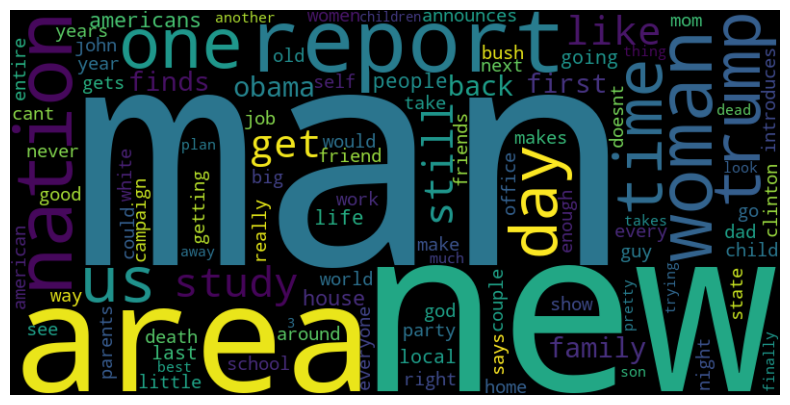

In [11]:
# View the most frequent words (excluding stop words) in sarcastic headlines by size; the (not stop) words "man" and "new" appear in sarcastic headlines most frequently  
not_stop_sarcastic_words = dict([(key, value) for key, value in word_counts.items() if key not in stop_words])

# Create a WordCloud object generated from the dictionary that maps the the most frequent not stop words in sarcastic headlines to their frequencies 
wordcloud = WordCloud(width = 800, height = 400, background_color = 'black', max_words = 100).generate_from_frequencies(not_stop_sarcastic_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

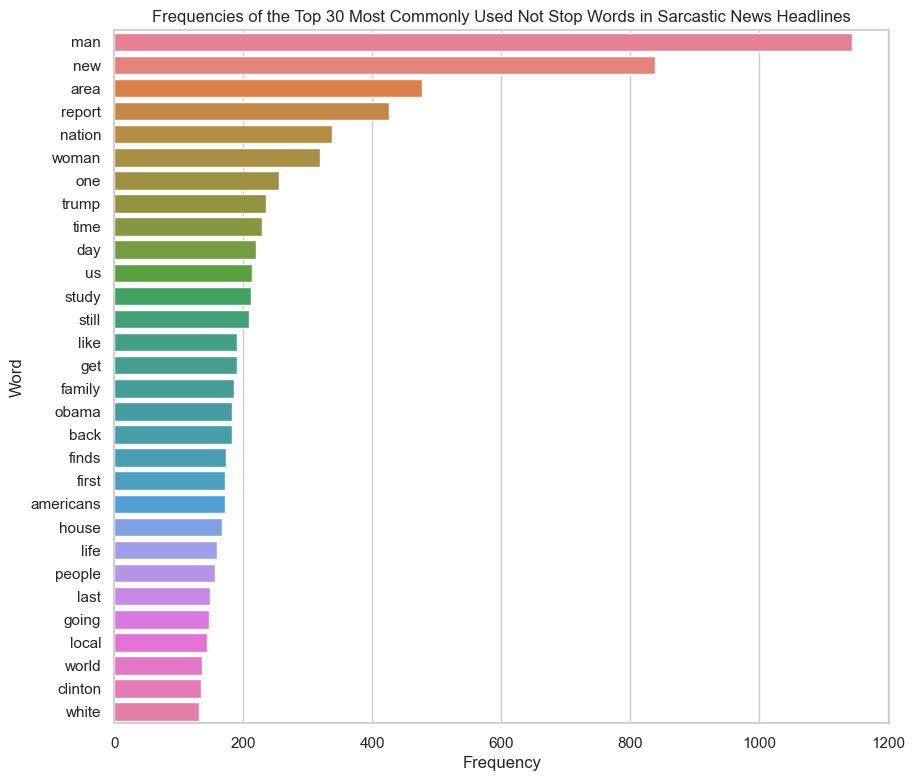

In [12]:
# View the frequencies of the top 30 most commonly used not stop words in sarcastic headlines; "man", "new", and "area" are the most frequent not stop words in sarcastic headlines
top_30_sarcastic_words_frequencies = [(key, value) for key, value in not_stop_sarcastic_words.items() if value >= 130]
top_30_sarcastic_words_frequencies_df = pd.DataFrame(top_30_sarcastic_words_frequencies, columns =['sarcastic_word', 'frequency']).sort_values(by = 'frequency', ascending = False)

fig = plt.gcf()
fig.set_size_inches(10, 9)
sns.set_theme(style = 'whitegrid')
sns.barplot(data = top_30_sarcastic_words_frequencies_df, x = 'frequency', y = 'sarcastic_word', hue = 'sarcastic_word').set(title='Frequencies of the Top 30 Most Commonly Used Not Stop Words in Sarcastic News Headlines')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

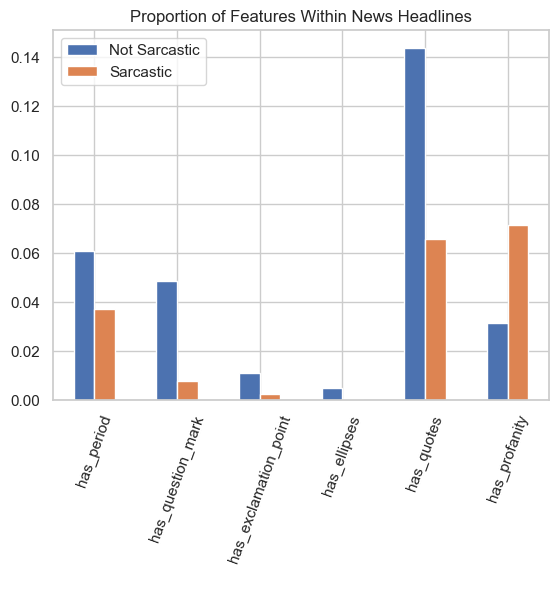

In [13]:
# View the proportion of sarcastic and non-sarcastic headlines with a period, question mark, exclamation point, ellipses, quotes, and profanity; profanity is more common among sarcastic headlines versus non-sarcastic headlines
grouped_df = news.groupby('is_sarcastic').sum()[['has_period', 'has_question_mark', 'has_exclamation_point', 'has_ellipses', 'has_quotes', 'has_profanity']]

total_non_sarcastic_headlines = news['is_sarcastic'].value_counts()[0]
total_sarcastic_headlines = news['is_sarcastic'].value_counts()[1]

non_sarcastic_metrics_df = pd.DataFrame(grouped_df.iloc[0] / total_non_sarcastic_headlines)
sarcastic_metrics_df = pd.DataFrame(grouped_df.iloc[1] / total_sarcastic_headlines)

metrics_df = pd.concat([non_sarcastic_metrics_df, sarcastic_metrics_df], axis = 1)
metrics_df = metrics_df.reset_index().rename(columns = {'index': ' ', 0: 'Not Sarcastic', 1: 'Sarcastic'})

metrics_df.plot.bar(x = ' ', y = ['Not Sarcastic', 'Sarcastic']).set_title('Proportion of Features Within News Headlines')
plt.xticks(rotation = 70)
plt.show()

# Modeling

In [14]:
# Split the data into the predictor variables X and the target variable y
X = news.drop(['article_link', 'headline', 'is_sarcastic', 'cleaned_headline'], axis = 1)
y = news['is_sarcastic']

# Designate 80% of the data for training and 20% of the data for testing
# Set a random_state to obtain the same split each time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Model 1: Logistic Regression

In [15]:
# Define a logistic regression model with an increased number of iterations to ensure convergence
LR = LogisticRegression(max_iter = 1000)

# Define a dictionary of C values to try 
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Use GridSearchCV with 5-fold cross-validation to find the optimal C value
LR_search = GridSearchCV(LR, param_grid, cv = 5, scoring = 'accuracy')

# Fit the logistic regression model for grid search
LR_search.fit(X_train, y_train)

# Store the optimal C value found
best_C = LR_search.best_params_['C']

print('Best C value: ' + str(best_C)) 

Best C value: 1


In [16]:
# Define the final logistic regression model with the optimal C value
LR_model = LogisticRegression(max_iter = 1000, C = best_C)

# Evaluate the accuracy of the final logistic regression model on the training data with 5-fold cross-validation
LR_model_validation_accuracy = cross_val_score(LR_model, X_train, y_train, cv = 5, scoring = 'accuracy').mean()

# Evaluate the precision of the final logistic regression model on the training data with 5-fold cross-validation
LR_model_validation_precision = cross_val_score(LR_model, X_train, y_train, cv = 5, scoring = 'precision').mean()

# Evaluate the recall of the final logistic regression model on the training data with 5-fold cross-validation
LR_model_validation_recall = cross_val_score(LR_model, X_train, y_train, cv = 5, scoring = 'recall').mean()

# Evaluate the F1 score of the final logistic regression model on the training data with 5-fold cross-validation
LR_model_validation_f1 = cross_val_score(LR_model, X_train, y_train, cv = 5, scoring = 'f1').mean()

print('Logistic Regression Model Validation Accuracy: ' + str(LR_model_validation_accuracy)) 
print('Logistic Regression Model Validation Precision: ' + str(LR_model_validation_precision)) 
print('Logistic Regression Model Validation Recall: ' + str(LR_model_validation_recall)) 
print('Logistic Regression Model Validation F1 Score: ' + str(LR_model_validation_f1)) 

Logistic Regression Model Validation Accuracy: 0.8144799138708286
Logistic Regression Model Validation Precision: 0.7879682235521478
Logistic Regression Model Validation Recall: 0.7900416773276474
Logistic Regression Model Validation F1 Score: 0.7889166164941441


In [17]:
# Fit the final logistic regression model on the training data 
LR_model.fit(X_train, y_train)

# Extract the predictions of the final logistic regression model 
LR_model_y_test_pred = LR_model.predict(X_test) 

# Evaluate the accuracy of the final logistic regression model on the unseen testing data 
LR_model_test_accuracy = accuracy_score(y_test, LR_model_y_test_pred)

# Evaluate the precision of the final logistic regression model on the unseen testing data 
LR_model_test_precision = precision_score(y_test, LR_model_y_test_pred)

# Evaluate the recall of the final logistic regression model on the unseen testing data 
LR_model_test_recall = recall_score(y_test, LR_model_y_test_pred)

# Evaluate the F1 score of the final logistic regression model on the unseen testing data 
LR_model_test_f1 = f1_score(y_test, LR_model_y_test_pred)

print('Logistic Regression Model Test Accuracy: ' + str(LR_model_test_accuracy)) 
print('Logistic Regression Model Test Precision: ' + str(LR_model_test_precision)) 
print('Logistic Regression Model Test Recall: ' + str(LR_model_test_recall)) 
print('Logistic Regression Model Test F1 Score: ' + str(LR_model_test_f1)) 

Logistic Regression Model Test Accuracy: 0.8193560464245601
Logistic Regression Model Test Precision: 0.7977576541612764
Logistic Regression Model Test Recall: 0.7885763000852515
Logistic Regression Model Test F1 Score: 0.7931404072883173


In [18]:
# Compute the confusion matrix for the final logistic regression model
matrix = confusion_matrix(y_test, LR_model_y_test_pred)
matrix

array([[2527,  469],
       [ 496, 1850]])

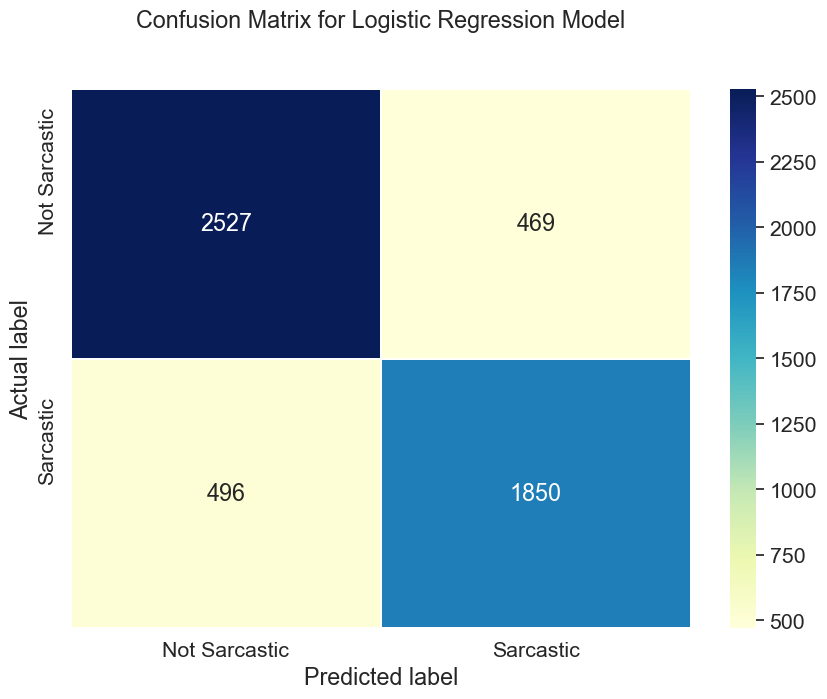

In [19]:
def plot_confusion_matrix(matrix, c): 
    '''
    Displays the results of a machine learning model in the form of a confusion matrix on a heat map.
    Parameter matrix is an array representing the confusion matrix to be visualized.
    Parameter c is a string representing the name of the machine learning model the confusion matrix was created from.
    Returns None, or nothing, as plot_confusion_matrix(matrix, c) is a void function.
    '''
    # Create a plot
    plt.figure(figsize = (10,7))
    # Scale the size of the font elements to be plotted 
    sns.set(font_scale = 1.4)
    # Create a heat map
    sns.heatmap(data = matrix,
                # Write the data value in each cell
                fmt = '.0f',
                annot = True,
                # Set the color theme 
                cmap = 'YlGnBu', 
                linewidths = 0.2)
    # Set the class names for each headline
    class_names = ['Not Sarcastic', 'Sarcastic']
    # Center the tick marks for each cell along each axis
    tick_marks = np.arange(len(class_names)) + 0.3 
    tick_marks2 = tick_marks + 0.2
    # Plot the tick marks
    plt.xticks(tick_marks2, class_names)
    plt.yticks(tick_marks, class_names)
    # Set the title with clear space beween it and the heat map for readability
    plt.title('Confusion Matrix for ' + c, y = 1.1)
    # Set the axis labels
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix of the final logistic regression model 
plot_confusion_matrix(matrix, 'Logistic Regression Model')

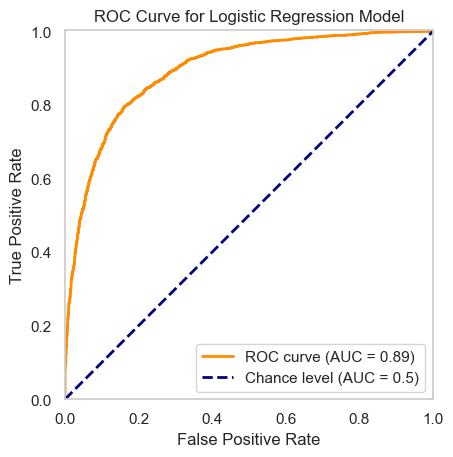

In [20]:
def plot_roc_curve(model, c):
    '''
    Displays the ROC curve of a machine learning model.
    Parameter model is a machine learning model.
    Parameter c is a string representing the name of the machine learning model.
    Returns None, or nothing, as plot_roc_curve(model) is a void function.
    '''
    # Store the model's predicted probabilities of class 1 for the test set
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Compute the AUC (area under the ROC curve) score
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Plot the ROC curve
    sns.set_theme(style = 'whitegrid')
    plt.grid(False)
    plt.axis('square')
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--', label = 'Chance level (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.005])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for ' + c)
    plt.legend()
    plt.show()

# Plot the ROC curve of the final logistic regression model 
plot_roc_curve(LR_model, 'Logistic Regression Model') 

## Model 2: Random Forest

In [21]:
# Give a random seeding so the same random forest model is initialized each time 
np.random.seed(1234)

# Initialize the best_accuracy variable
best_accuracy = -np.inf

# Loop through the hyperparameter values to try
for i in range(10, 30): # Try values for n_estimators in the range (10, 30)
    for j in range(8, 20): # Try values for max_depth in the range (8, 20)
        
        # Initialize and fit the random forest model with the hyperparameter values to try
        RF = RandomForestClassifier(n_estimators = i, max_depth = j) 
        RF.fit(X_train, y_train)
        
        # Evaluate the accuracy of the random forest model on the training data with 5-fold cross-validation
        RF_validation_accuracy = cross_val_score(RF, X_train, y_train, cv = 5, scoring = 'accuracy').mean()

        # Select the optimal hyperparameter values that give the best accuracy with 5-fold cross-validation
        if RF_validation_accuracy > best_accuracy:
            best_accuracy = RF_validation_accuracy
            best_est = i 
            best_depth = j
    
print('Best n_estimators value: ' + str(best_est)) 
print('Best max_depth value: ' + str(best_depth))   

Best n_estimators value: 29
Best max_depth value: 19


In [22]:
# Give a random seeding so the same random forest model is initialized each time    
np.random.seed(1234)

# Define the final random forest model with the optimal n_estimators and max_depth values  
RF_model = RandomForestClassifier(n_estimators = best_est, max_depth = best_depth) 

# Evaluate the accuracy of the final random forest model on the training data with 5-fold cross-validation
RF_model_validation_accuracy = cross_val_score(RF_model, X_train, y_train, cv = 5, scoring = 'accuracy').mean()

# Evaluate the precision of the final random forest model on the training data with 5-fold cross-validation
RF_model_validation_precision = cross_val_score(RF_model, X_train, y_train, cv = 5, scoring = 'precision').mean()

# Evaluate the recall of the final random forest model on the training data with 5-fold cross-validation
RF_model_validation_recall = cross_val_score(RF_model, X_train, y_train, cv = 5, scoring = 'recall').mean()

# Evaluate the F1 score of the final random forest model on the training data with 5-fold cross-validation
RF_model_validation_f1 = cross_val_score(RF_model, X_train, y_train, cv = 5, scoring = 'f1').mean()

print('Random Forest Model Validation Accuracy: ' + str(RF_model_validation_accuracy)) 
print('Random Forest Model Validation Precision: ' + str(RF_model_validation_precision)) 
print('Random Forest Model Validation Recall: ' + str(RF_model_validation_recall)) 
print('Random Forest Model Validation F1 Score: ' + str(RF_model_validation_f1))   

Random Forest Model Validation Accuracy: 0.7431087628283983
Random Forest Model Validation Precision: 0.8033301308062315
Random Forest Model Validation Recall: 0.6141050746268657
Random Forest Model Validation F1 Score: 0.6631832462244858


In [23]:
# Fit the final random forest model on the training data
RF_model.fit(X_train, y_train)

# Extract the predictions of the final random forest model 
RF_model_y_test_pred = RF_model.predict(X_test) 

# Evaluate the accuracy of the final random forest model on the unseen testing data 
RF_model_test_accuracy = accuracy_score(y_test, RF_model_y_test_pred)

# Evaluate the precision of the final random forest model on the unseen testing data 
RF_model_test_precision = precision_score(y_test, RF_model_y_test_pred)

# Evaluate the recall of the final random forest model on the unseen testing data 
RF_model_test_recall = recall_score(y_test, RF_model_y_test_pred)

# Evaluate the F1 score of the final random forest model on the unseen testing data 
RF_model_test_f1 = f1_score(y_test, RF_model_y_test_pred)

print('Random Forest Model Test Accuracy: ' + str(RF_model_test_accuracy)) 
print('Random Forest Model Test Precision: ' + str(RF_model_test_precision)) 
print('Random Forest Model Test Recall: ' + str(RF_model_test_recall)) 
print('Random Forest Model Test F1 Score: ' + str(RF_model_test_f1)) 

Random Forest Model Test Accuracy: 0.7616997379258704
Random Forest Model Test Precision: 0.8085106382978723
Random Forest Model Test Recall: 0.5993179880647911
Random Forest Model Test F1 Score: 0.6883720930232557


In [24]:
# Compute the confusion matrix for the final random forest model 
matrix = confusion_matrix(y_test, RF_model_y_test_pred)
matrix

array([[2663,  333],
       [ 940, 1406]])

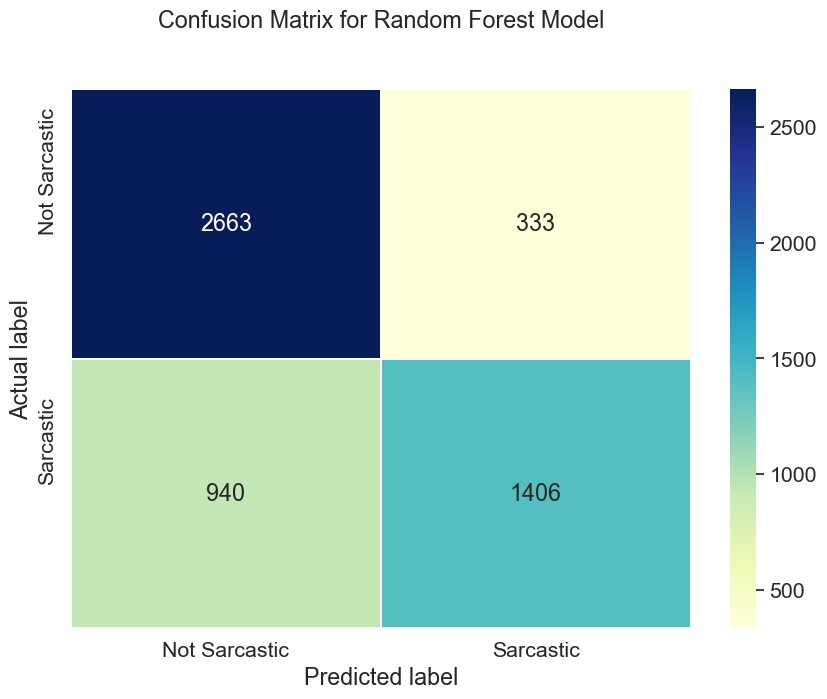

In [25]:
# Plot the confusion matrix of the final random forest model 
plot_confusion_matrix(matrix, 'Random Forest Model')

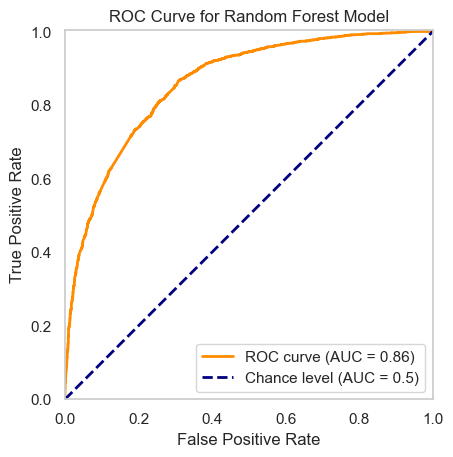

In [26]:
# Plot the ROC curve of the final random forest model 
plot_roc_curve(RF_model, 'Random Forest Model') 

## Model 3: Multilayer Perceptron Neural Network

In [27]:
# Give a random seeding so the same MLP model is initialized each time 
np.random.seed(1234)

# Define an MLP model with ReLU activation, no default L2 regularization term, and early_stopping 
MLP = MLPClassifier(activation = 'relu', alpha = 0, early_stopping = True)

# Define a dictionary of hidden layer sizes to try 
param_grid = {'hidden_layer_sizes': [(100, 50, 50), (100, 100, 50), (100, 100, 100)]}

# Use GridSearchCV with 5-fold cross-validation to find the optimal hidden layer sizes
MLP_search = GridSearchCV(MLP, param_grid, cv = 5)

# Fit the MLP model for grid search
MLP_search.fit(X_train, y_train)

# Store the optimal hidden layer sizes found
best_hidden_layer_sizes = MLP_search.best_params_['hidden_layer_sizes']

print('Best hidden layer sizes: ' + str(best_hidden_layer_sizes)) 

Best hidden layer sizes: (100, 100, 50)


In [28]:
# Give a random seeding so the same MLP model is initialized each time 
np.random.seed(1234)

# Define the final MLP model with the optimal hidden layer sizes
MLP_model = MLPClassifier(activation = 'relu', alpha = 0, early_stopping = True, hidden_layer_sizes = best_hidden_layer_sizes)

# Evaluate the accuracy of the final MLP model on the training data with 5-fold cross-validation
MLP_model_validation_accuracy = cross_val_score(MLP_model, X_train, y_train, cv = 5, scoring = 'accuracy').mean()

# Evaluate the precision of the final MLP model on the training data with 5-fold cross-validation
MLP_model_validation_precision = cross_val_score(MLP_model, X_train, y_train, cv = 5, scoring = 'precision').mean()

# Evaluate the recall of the final MLP model on the training data with 5-fold cross-validation
MLP_model_validation_recall = cross_val_score(MLP_model, X_train, y_train, cv = 5, scoring = 'recall').mean()

# Evaluate the F1 score of the final MLP model on the training data with 5-fold cross-validation
MLP_model_validation_f1 = cross_val_score(MLP_model, X_train, y_train, cv = 5, scoring = 'f1').mean()

print('Multilayer Perceptron Neural Network Model Validation Accuracy: ' + str(MLP_model_validation_accuracy)) 
print('Multilayer Perceptron Neural Network Model Validation Precision: ' + str(MLP_model_validation_precision)) 
print('Multilayer Perceptron Neural Networkt Model Validation Recall: ' + str(MLP_model_validation_recall)) 
print('Multilayer Perceptron Neural Network Model Validation F1 Score: ' + str(MLP_model_validation_f1))   

Multilayer Perceptron Neural Network Model Validation Accuracy: 0.8095189774274507
Multilayer Perceptron Neural Network Model Validation Precision: 0.7893852671814469
Multilayer Perceptron Neural Networkt Model Validation Recall: 0.7872665813788202
Multilayer Perceptron Neural Network Model Validation F1 Score: 0.7818362734996309


In [29]:
# Fit the final MLP model on the training data 
MLP_model.fit(X_train, y_train)

# Extract the predictions of the final MLP model 
MLP_model_y_test_pred = MLP_model.predict(X_test)

# Evaluate the accuracy of the final MLP model on the unseen testing data 
MLP_model_test_accuracy = accuracy_score(y_test, MLP_model_y_test_pred)

# Evaluate the precision of the final MLP model on the unseen testing data 
MLP_model_test_precision = precision_score(y_test, MLP_model_y_test_pred)

# Evaluate the recall of the final MLP model on the unseen testing data 
MLP_model_test_recall = recall_score(y_test, MLP_model_y_test_pred)

# Evaluate the F1 score of the final MLP model on the unseen testing data 
MLP_model_test_f1 = f1_score(y_test, MLP_model_y_test_pred)

print('Multilayer Perceptron Neural Network Model Test Accuracy: ' + str(MLP_model_test_accuracy)) 
print('Multilayer Perceptron Neural Network Model Test Precision: ' + str(MLP_model_test_precision)) 
print('Multilayer Perceptron Neural Network Model Test Recall: ' + str(MLP_model_test_recall)) 
print('Multilayer Perceptron Neural Network Model Test F1 Score: ' + str(MLP_model_test_f1)) 

Multilayer Perceptron Neural Network Model Test Accuracy: 0.8163609135155373
Multilayer Perceptron Neural Network Model Test Precision: 0.8037383177570093
Multilayer Perceptron Neural Network Model Test Recall: 0.7698209718670077
Multilayer Perceptron Neural Network Model Test F1 Score: 0.7864141084258655


In [30]:
# Compute the confusion matrix for the final MLP model
matrix = confusion_matrix(y_test, MLP_model_y_test_pred)
matrix

array([[2555,  441],
       [ 540, 1806]])

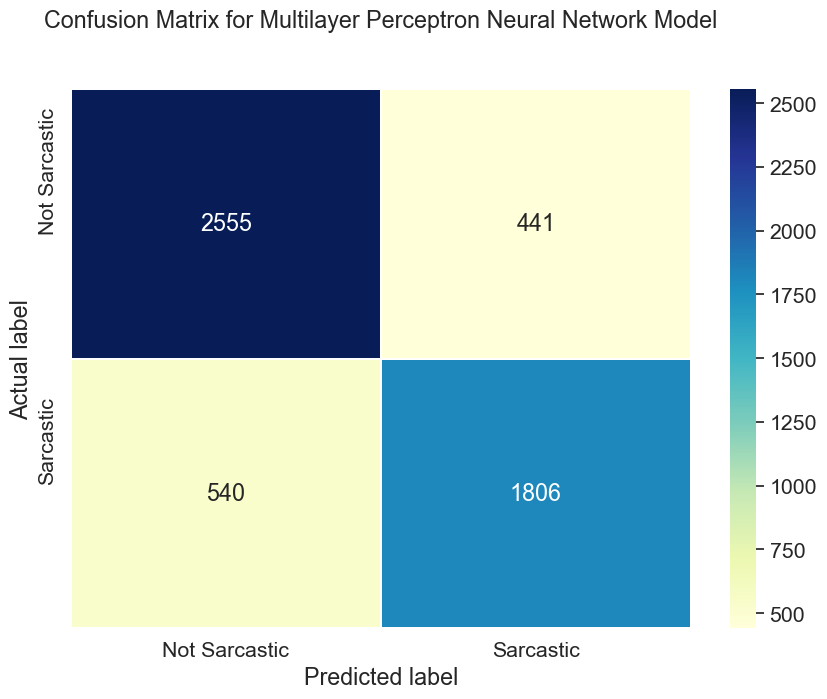

In [31]:
# Plot the confusion matrix of the final MLP model 
plot_confusion_matrix(matrix, 'Multilayer Perceptron Neural Network Model')

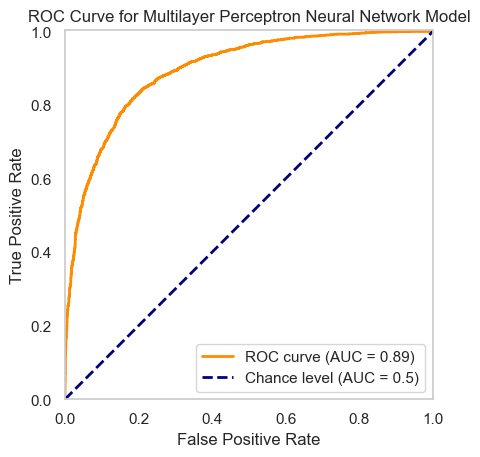

In [32]:
# Plot the ROC curve of the final MLP model
plot_roc_curve(MLP_model, 'Multilayer Perceptron Neural Network Model') 

# Model Comparison

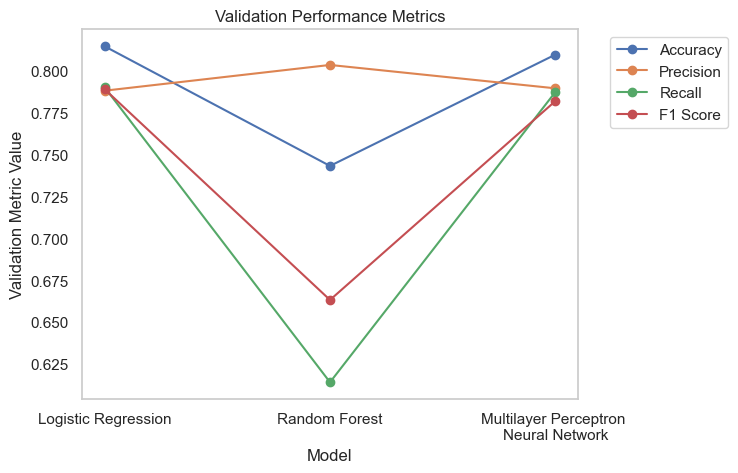

In [58]:
# View the validation metrics for each model; the logistic regression model yields the best accuracy and F1 score on the validation set 

# Store the model names
models = ['Logistic Regression', 'Random Forest', 'Multilayer Perceptron \nNeural Network']

# Store the validation accuracy values
accuracy_values = [LR_model_validation_accuracy, RF_model_validation_accuracy, MLP_model_validation_accuracy]

# Store the validation precision values
precision_values = [LR_model_validation_precision, RF_model_validation_precision, MLP_model_validation_precision]

# Store the validation recall values
recall_values = [LR_model_validation_recall, RF_model_validation_recall, MLP_model_validation_recall]

# Store the validation F1 score values
f1_values = [LR_model_validation_f1, RF_model_validation_f1, MLP_model_validation_f1]
  
# Plot the validation metrics for each model
plt.grid(False)
plt.plot(models, accuracy_values, marker = 'o', label = 'Accuracy')
plt.plot(models, precision_values, marker = 'o', label = 'Precision')
plt.plot(models, recall_values, marker = 'o', label = 'Recall')
plt.plot(models, f1_values, marker = 'o', label = 'F1 Score')

plt.title('Validation Performance Metrics')
plt.xlabel('Model')
plt.ylabel('Validation Metric Value')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.show()

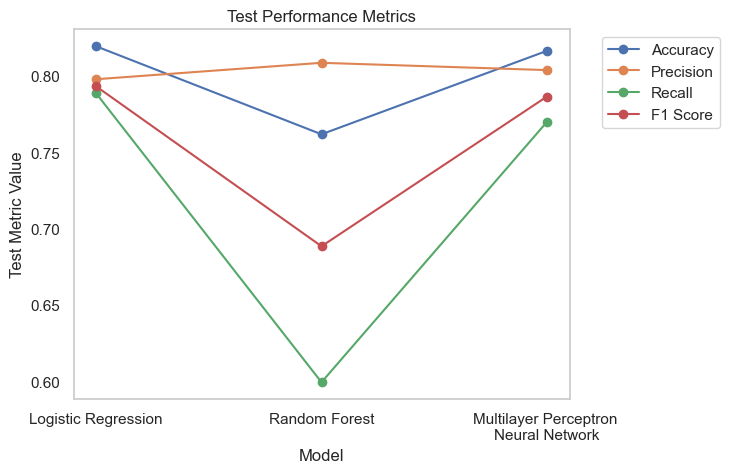

In [59]:
# View the test metrics for each model; the logistic regression model yields the best accuracy and F1 score on the test set 

# Store the test accuracy values
accuracy_values = [LR_model_test_accuracy, RF_model_test_accuracy, MLP_model_test_accuracy]

# Store the test precision values
precision_values = [LR_model_test_precision, RF_model_test_precision, MLP_model_test_precision]

# Store the test recall values
recall_values = [LR_model_test_recall, RF_model_test_recall, MLP_model_test_recall]

# Store the test F1 score values
f1_values = [LR_model_test_f1, RF_model_test_f1, MLP_model_test_f1]

# Plot the test metrics for each model
plt.grid(False)
plt.plot(models, accuracy_values, marker = 'o', label = 'Accuracy')
plt.plot(models, precision_values, marker = 'o', label = 'Precision')
plt.plot(models, recall_values, marker = 'o', label = 'Recall')
plt.plot(models, f1_values, marker = 'o', label = 'F1 Score')

plt.title('Test Performance Metrics')
plt.xlabel('Model')
plt.ylabel('Test Metric Value')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.show()